## Product Sales Recommendation System

### 1. Import Libraries

In [10]:
import pandas as pd
import numpy as np
import re
import warnings
import joblib
import json
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# import xgboost
try:
    from xgboost import XGBClassifier
    xgb_ready = True
except:
    xgb_ready = False
    print("XGBoost belum ter-install")

# SMOTE untuk handle imbalance
try:
    from imblearn.over_sampling import SMOTE
    smote_ready = True
except:
    smote_ready = False
    print("imbalanced-learn belum ter-install")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load & Explore Dataset

In [11]:
# load dataset
df = pd.read_csv('Dataset.csv')

print("\n=== Dataset Info ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")
print(df.head())

# colomn to use
product_col = 'Nama Produk'
review_col = 'comment-'
rating_col = 'rating'

print(f"\nKolom produk: {product_col}")
print(f"Kolom review: {review_col}")
print(f"Kolom rating: {rating_col}")


=== Dataset Info ===
Shape: (11204, 5)
Columns: ['Nama Produk', 'price', 'rating', 'item_sold', 'comment-']

                   Nama Produk         price  rating item_sold  \
0  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
1  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
2  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
3  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
4  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   

                                            comment-  
0  Pertama kalinya beli Hape online dan alhamduli...  
1  Fungsi: Sesuai harapan Kondisi Barang: Baru, m...  
2  Fungsi: Sangat memuaskan Kondisi Barang: Baru ...  
3  Fungsi: Oke semua Kondisi Barang: Baru dan seg...  
4                   Terima kasih, akan repeat order.  

Kolom produk: Nama Produk
Kolom review: comment-
Kolom rating: rating


### 3. Text Preprocessing

In [12]:
def preprocess_text(text, use_stemming=False, use_stopword=True):
    # handle empty
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text).lower()
    
    # hapus simbol dll.
    text = re.sub(r'http\S+|www\S+|<.*?>|\S+@\S+|@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    if len(text) == 0:
        return ''
    
    # stopword removal
    if use_stopword:
        try:
            factory = StopWordRemoverFactory()
            remover = factory.create_stop_word_remover()
            text = remover.remove(text)
        except:
            pass
    
    # stemming
    if use_stemming:
        try:
            stemmer = StemmerFactory().create_stemmer()
            text = stemmer.stem(text)
        except:
            pass
    
    return text

# test preprocessing
sample = "Produk ini SANGAT bagus! Recommended 100% 😊"
print(f"Before: {sample}")
print(f"After: {preprocess_text(sample)}")

Before: Produk ini SANGAT bagus! Recommended 100% 😊
After: produk sangat bagus recommended


### 4. Data Cleaning & Preprocessing

In [13]:
# preprocessing review
df['cleaned_review'] = df['comment-'].apply(lambda x: preprocess_text(x, use_stemming=False))

# hapus review yang kosong
n_before = len(df)
df = df[df['cleaned_review'].str.len() > 0]
print(f"Removed {n_before - len(df)} empty reviews, sisa: {len(df)}")

# label sentiment: rating >= 4 = positive (1), sisanya negative (0)
df['sentiment_binary'] = (df[rating_col] >= 4).astype(int)

print(f"\nDistribusi sentiment:")
print(df['sentiment_binary'].value_counts())
print(f"Persentase positive: {df['sentiment_binary'].mean()*100:.1f}%")

Removed 4348 empty reviews, sisa: 6856

Distribusi sentiment:
sentiment_binary
1    6660
0     196
Name: count, dtype: int64
Persentase positive: 97.1%


### 5. Train-Test Split & TF-IDF Vectorization

In [14]:
# split data train-test
X = df['cleaned_review']
y = df['sentiment_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)

print(f"Data train: {len(X_train)} | Data test: {len(X_test)}")

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=2, 
    max_df=0.95
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Total features: {X_train_tfidf.shape[1]}")

# save vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

Data train: 5484 | Data test: 1372
Total features: 5000


['tfidf_vectorizer.pkl']

### 6. Handle Class Imbalance with SMOTE

In [15]:
# balancing data using SMOTE
if smote_ready:
    smote = SMOTE(random_state=SEED)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)
    print(f"SMOTE applied - total samples: {X_train_balanced.shape[0]}")
    print(pd.Series(y_train_balanced).value_counts())
else:
    X_train_balanced = X_train_tfidf
    y_train_balanced = y_train
    print("SMOTE not available, using imbalanced data")

SMOTE applied - total samples: 10654
sentiment_binary
1    5327
0    5327
Name: count, dtype: int64


### 7. MODEL COMPARISON - Sentiment Analysis

#### Model 1: Logistic Regression

In [16]:
results = {}

print("Logistic Regression")
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(X_train_balanced, y_train_balanced)
y_pred_lr = lr.predict(X_test_tfidf)
y_proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_proba_lr)
}

lr_f1 = results['Logistic Regression']['f1']
lr_auc = results['Logistic Regression']['roc_auc']
print(f"F1-Score: {lr_f1:.4f} | ROC-AUC: {lr_auc:.4f}")

Logistic Regression
F1-Score: 0.9773 | ROC-AUC: 0.9264


#### Model 2 : Random Forest

In [17]:
print("Random Forest")
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=SEED, 
    n_jobs=-1
)
rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf.predict(X_test_tfidf)
y_proba_rf = rf.predict_proba(X_test_tfidf)[:, 1]

results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_proba_rf)
}

rf_f1 = results['Random Forest']['f1']
rf_auc = results['Random Forest']['roc_auc']
print(f"F1-Score: {rf_f1:.4f} | ROC-AUC: {rf_auc:.4f}")

Random Forest
F1-Score: 0.9817 | ROC-AUC: 0.8697


#### Model 3 : SVM

In [18]:
print("SVM")
svm = SVC(kernel='linear', probability=True, random_state=SEED)
svm.fit(X_train_balanced, y_train_balanced)
y_pred_svm = svm.predict(X_test_tfidf)
y_proba_svm = svm.predict_proba(X_test_tfidf)[:, 1]

results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'roc_auc': roc_auc_score(y_test, y_proba_svm)
}

svm_f1 = results['SVM']['f1']
svm_auc = results['SVM']['roc_auc']
print(f"F1-Score: {svm_f1:.4f} | ROC-AUC: {svm_auc:.4f}")

SVM
F1-Score: 0.9820 | ROC-AUC: 0.8196


#### Model 4 : Deep Neural Network (DNN)

In [19]:
print("DNN")

dnn = Sequential([
    Dense(256, activation='relu', input_dim=X_train_balanced.shape[1]),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

dnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# callback buat early stopping & reduce lr kalo stuck
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True, 
    verbose=0
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    min_lr=0.00001, 
    verbose=0
)

# training
history = dnn.fit(
    X_train_balanced.toarray(), y_train_balanced,
    validation_data=(X_test_tfidf.toarray(), y_test),
    epochs=50, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

y_pred_dnn_proba = dnn.predict(X_test_tfidf.toarray(), verbose=0).flatten()
y_pred_dnn = (y_pred_dnn_proba > 0.5).astype(int)

results['DNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_dnn),
    'precision': precision_score(y_test, y_pred_dnn),
    'recall': recall_score(y_test, y_pred_dnn),
    'f1': f1_score(y_test, y_pred_dnn),
    'roc_auc': roc_auc_score(y_test, y_pred_dnn_proba)
}

dnn_f1 = results['DNN']['f1']
dnn_auc = results['DNN']['roc_auc']
print(f"F1-Score: {dnn_f1:.4f} | ROC-AUC: {dnn_auc:.4f}")

DNN
F1-Score: 0.9855 | ROC-AUC: 0.8349


#### Model Comparison Results

In [20]:
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*70)
print("Perbandingan Performa Model Sentiment Analysis")
print("="*70)
print(comparison_df.to_string())

# model terbaik berdasarkan F1-score
best_model = comparison_df['f1'].idxmax()
best_f1 = comparison_df.loc[best_model, 'f1']
best_auc = comparison_df.loc[best_model, 'roc_auc']

print(f"\nBest Model: {best_model}")
print(f"F1-Score: {best_f1:.4f}")
print(f"ROC-AUC: {best_auc:.4f}")

# save comparison result
comparison_df.to_csv('sentiment_model_comparison.csv')


Perbandingan Performa Model Sentiment Analysis
                     accuracy  precision  recall      f1  roc_auc
Logistic Regression    0.9563     0.9870  0.9677  0.9773   0.9264
Random Forest          0.9643     0.9784  0.9850  0.9817   0.8697
SVM                    0.9650     0.9820  0.9820  0.9820   0.8196
DNN                    0.9716     0.9743  0.9970  0.9855   0.8349

Best Model: DNN
F1-Score: 0.9855
ROC-AUC: 0.8349


#### Visualization - Model Comparison

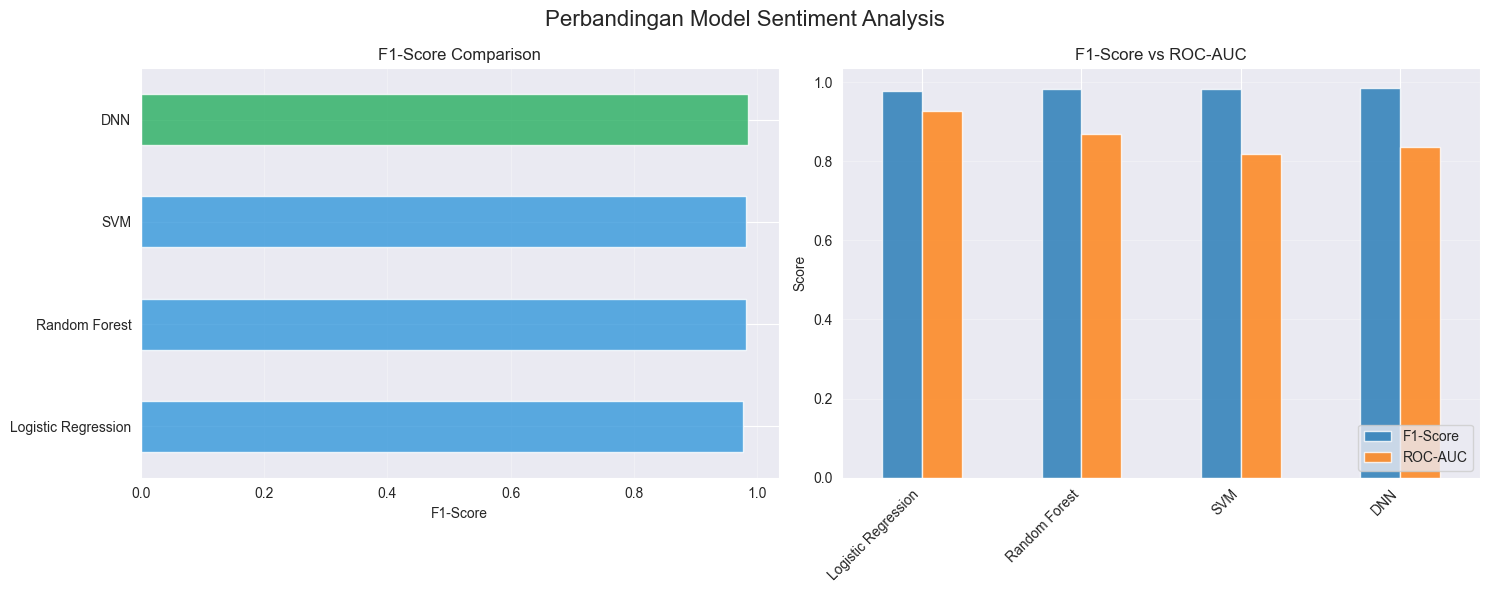

In [21]:
# visualisasi perbandingan model
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Perbandingan Model Sentiment Analysis', fontsize=16)

# plot 1: f1-score comparison
ax1 = axes[0]
sorted_f1 = comparison_df.sort_values('f1')
colors = ['#27ae60' if model == best_model else '#3498db' for model in sorted_f1.index]
sorted_f1.plot(
    kind='barh', 
    y='f1', 
    ax=ax1,
    color=colors, 
    alpha=0.8, 
    legend=False
)
ax1.set_xlabel('F1-Score')
ax1.set_title('F1-Score Comparison')
ax1.grid(axis='x', alpha=0.3)

# plot 2: f1-score vs roc-auc
ax2 = axes[1]
main_metrics = ['f1', 'roc_auc']
comparison_df[main_metrics].plot(kind='bar', ax=ax2, alpha=0.8)
ax2.set_ylabel('Score')
ax2.set_title('F1-Score vs ROC-AUC')
ax2.legend(['F1-Score', 'ROC-AUC'], loc='lower right')
ax2.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('sentiment_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 8. Retrain DNN (Best Sentiment Model) dengan Full Settings

In [22]:
# retrain best model dengan full data
sentiment_model = Sequential([
    Dense(256, activation='relu', input_dim=X_train_balanced.shape[1]),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

sentiment_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# callbacks untuk training optimization
checkpoint = ModelCheckpoint(
    'best_sentiment_model.h5', 
    save_best_only=True,
    monitor='val_loss', 
    verbose=0
)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True, 
    verbose=0
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    min_lr=0.00001, 
    verbose=0
)

# training final model
history = sentiment_model.fit(
    X_train_balanced.toarray(), y_train_balanced,
    validation_data=(X_test_tfidf.toarray(), y_test),
    epochs=50, 
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print(f"\n{best_model} model saved to 'best_sentiment_model.h5'")

Epoch 1/50
328/333 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8332 - auc: 0.9033 - loss: 0.3458

333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9283 - auc: 0.9831 - loss: 0.1670 - val_accuracy: 0.9716 - val_auc: 0.8669 - val_loss: 0.1015 - learning_rate: 0.0010
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9912 - auc: 0.9988 - loss: 0.0295 - val_accuracy: 0.9701 - val_auc: 0.7528 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9927 - auc: 0.9990 - loss: 0.0227 - val_accuracy: 0.9694 - val_auc: 0.6922 - val_loss: 0.2306 - learning_rate: 0.0010
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9952 - auc: 0.9994 - loss: 0.0164 - val_accuracy: 0.9694 - val_auc: 0.6952 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9960 - auc: 0.9995 - loss: 0.0139 - val_accuracy: 0.9672 - val_auc: 0.6813 - val_loss: 0.2817 - learning_rate: 0.0010
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9971 - auc: 0.9998 

### 9. Evaluate Final Sentiment Model


Evaluasi Final Model - DNN

F1-Score: 0.9855
ROC-AUC: 0.8709

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.18      0.26        39
    Positive       0.98      0.99      0.99      1333

    accuracy                           0.97      1372
   macro avg       0.74      0.59      0.62      1372
weighted avg       0.96      0.97      0.97      1372



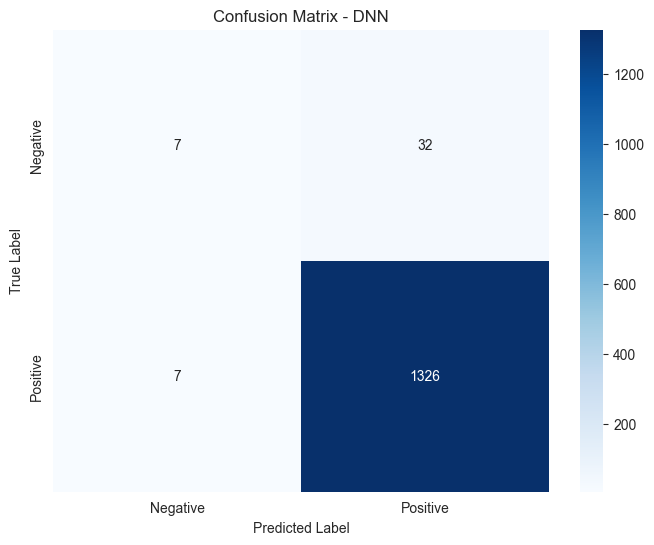


Confusion matrix saved to 'confusion_matrix_sentiment.png'


In [23]:
# evaluasi final model
y_pred_proba_final = sentiment_model.predict(X_test_tfidf.toarray(), verbose=0).flatten()
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print("\n" + "="*70)
print(f"Evaluasi Final Model - {best_model}")
print("="*70)

# hitung metrics utama
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print(f"\nF1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred_final,
    target_names=['Negative', 'Positive']
))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to 'confusion_matrix_sentiment.png'")

### 10. Generate Sentiment Predictions

In [24]:
# generate sentiment predictions untuk semua review
print(f"\nGenerating sentiment predictions dengan {best_model}...")

X_full_tfidf = vectorizer.transform(df['cleaned_review'])
raw_scores = sentiment_model.predict(X_full_tfidf.toarray(), verbose=0).flatten()

print(f"Raw sentiment range: {raw_scores.min():.4f} - {raw_scores.max():.4f}")

# adjust sentiment based on rating untuk alignment
# alasan: DNN prediksi dari text, tapi rating dari user bisa jadi ground truth tambahan
def adjust_sentiment(rating, sentiment):
    if rating <= 1:
        return min(sentiment, 0.35)
    elif rating <= 2:
        return min(sentiment, 0.50)
    elif rating == 3:
        return max(min(sentiment, 0.70), 0.40)
    elif rating == 4:
        return max(min(sentiment, 0.90), 0.65)
    else:  # rating 5
        return min(max(sentiment, 0.80), 0.95)

df['sentiment_score'] = [
    adjust_sentiment(r, s)
    for r, s in zip(df[rating_col], raw_scores)
]

# statistik hasil adjustment
n_adjusted = (df['sentiment_score'] != raw_scores).sum()
pct_adjusted = (n_adjusted / len(df)) * 100

print(f"Adjusted sentiment range: {df['sentiment_score'].min():.4f} - {df['sentiment_score'].max():.4f}")
print(f"Mean sentiment: {df['sentiment_score'].mean():.4f}")
print(f"Reviews adjusted: {n_adjusted} ({pct_adjusted:.1f}%)")


Generating sentiment predictions dengan DNN...
Raw sentiment range: 0.0402 - 0.9964
Adjusted sentiment range: 0.0402 - 0.9500
Mean sentiment: 0.9269
Reviews adjusted: 5319 (77.6%)


### 11. Aggregate Data by Product

In [25]:
# hitung positive rate (rating >= 4)
positive_rates = df.groupby(product_col).apply(
    lambda x: (x[rating_col] >= 4).mean()
).reset_index(name='positive_rate')

# statistik sentiment dan rating per produk
product_stats = df.groupby(product_col).agg({
    'sentiment_score': ['mean', 'std'],
    rating_col: ['mean', 'std', 'count'],
    'cleaned_review': lambda x: x.str.len().mean(),
    'item_sold': 'first'
}).reset_index()

# flatten column names
product_stats.columns = [
    product_col, 'avg_sentiment', 'std_sentiment',
    'avg_rating', 'std_rating', 'review_count', 
    'avg_review_length', 'item_sold'
]

product_stats = product_stats.merge(positive_rates, on=product_col)

# handle edge cases untuk produk dengan review sedikit
# std = 0 atau NaN (produk cuma punya 1 review) -> set ke 0.1 biar ga error di model
product_stats['std_sentiment'] = product_stats['std_sentiment'].fillna(0.1).replace(0, 0.1)
product_stats['std_rating'] = product_stats['std_rating'].fillna(0.1).replace(0, 0.1)

# convert item_sold ke numeric
product_stats['item_sold'] = pd.to_numeric(product_stats['item_sold'], errors='coerce').fillna(0)

print(f"\nTotal products: {len(product_stats)}")
print(f"Reviews per product: min={product_stats['review_count'].min()}, "
      f"max={product_stats['review_count'].max()}, "
      f"mean={product_stats['review_count'].mean():.1f}")

print(f"\nStatistik item sold:")
print(product_stats['item_sold'].describe())

# check produk dengan review sedikit (potential outlier)
low_review_products = (product_stats['review_count'] < 5).sum()
print(f"\nProduk dengan < 5 reviews: {low_review_products} ({low_review_products/len(product_stats)*100:.1f}%)")

print(f"\nSample data:")
print(product_stats.head())


Total products: 1627
Reviews per product: min=1, max=5, mean=4.2

Statistik item sold:
count    1627.000000
mean      102.183835
std       205.666056
min         0.000000
25%         1.000000
50%        10.000000
75%        80.500000
max       987.000000
Name: item_sold, dtype: float64

Produk dengan < 5 reviews: 442 (27.2%)

Sample data:
                                         Nama Produk  avg_sentiment  \
0                   2in1 Vacuum & Mopping Function)"       0.947113   
1  A416JAO-VIPS524 14", i5-1035G1/UMA/4G/256G PCI...       0.946483   
2  A416MAO-VIPS521 14",N5030/UMA/4G/256G PCIE/VIP...       0.937491   
3         ASUS - E410MAO-HD455 INTEL® CELERON® N4020       0.948250   
4  ASUS A1400EA-FHD322 14",I3-1115G4/UMA/4GB/256G...       0.923850   

   std_sentiment  avg_rating  std_rating  review_count  avg_review_length  \
0       0.006455         4.9         0.1             5          68.600000   
1       0.004974         5.0         0.1             2         214.000000   


### 12. Create Binary Target for Sales Classification

In [26]:
# target binary untuk sales classification
print("\n" + "="*70)
print("Binary Target Creation - Sales Classification")
print("="*70)

# analisis distribusi item_sold
print(f"\nDistribusi item_sold:")
print(f"Min: {product_stats['item_sold'].min():.0f}")
print(f"Q1: {product_stats['item_sold'].quantile(0.25):.0f}")
print(f"Median: {product_stats['item_sold'].median():.0f}")
print(f"Q3: {product_stats['item_sold'].quantile(0.75):.0f}")
print(f"Max: {product_stats['item_sold'].max():.0f}")
print(f"Mean: {product_stats['item_sold'].mean():.1f}")

# median sebagai threshold (robust terhadap outlier)
median_sales = product_stats['item_sold'].median()
print(f"\nThreshold dipilih: {median_sales:.0f} (median)")
print("Alasan: Median lebih robust terhadap outlier dibanding mean")

# sales_category: 1 = high seller (>= median), 0 = low seller (< median)
product_stats['sales_category'] = (product_stats['item_sold'] >= median_sales).astype(int)

print(f"\nDistribusi sales category:")
print(product_stats['sales_category'].value_counts())

n_high = (product_stats['sales_category'] == 1).sum()
n_low = (product_stats['sales_category'] == 0).sum()
print(f"\nHigh Seller (>= {median_sales:.0f}): {n_high} products")
print(f"Low Seller (< {median_sales:.0f}): {n_low} products")

# cek class balance
balance_ratio = product_stats['sales_category'].mean()
imbalance_ratio = max(n_high, n_low) / min(n_high, n_low)

print(f"\nClass balance: {balance_ratio:.2%} high sellers")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

if balance_ratio < 0.4 or balance_ratio > 0.6:
    print("Status: Classes imbalanced - akan gunakan SMOTE dan class_weight='balanced'")
else:
    print("Status: Classes cukup balanced")


Binary Target Creation - Sales Classification

Distribusi item_sold:
Min: 0
Q1: 1
Median: 10
Q3: 80
Max: 987
Mean: 102.2

Threshold dipilih: 10 (median)
Alasan: Median lebih robust terhadap outlier dibanding mean

Distribusi sales category:
sales_category
1    838
0    789
Name: count, dtype: int64

High Seller (>= 10): 838 products
Low Seller (< 10): 789 products

Class balance: 51.51% high sellers
Imbalance ratio: 1.06:1
Status: Classes cukup balanced


### 13. Sales Prediction Using Machine Learning Model

In [27]:
# sales classification: model training & comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import time

print("\n" + "="*70)
print("Sales Classification - Model Training & Comparison")
print("="*70)

# prepare data
features = ['avg_sentiment', 'std_sentiment', 'positive_rate',
            'avg_rating', 'std_rating', 'review_count']

X_prod = product_stats[features]
y_prod = product_stats['sales_category']

X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(
    X_prod, y_prod, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_prod
)

print(f"Train: {len(X_train_prod)} samples | Test: {len(X_test_prod)} samples")
print(f"Train distribution: {y_train_prod.value_counts().to_dict()}")
print(f"Test distribution: {y_test_prod.value_counts().to_dict()}")

# define models
models = {
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=SEED,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=SEED
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=SEED
    )
}

# training & evaluation
sales_results = {}

for name, model in models.items():
    print(f"\n{name}")
    start = time.time()
    
    # training
    model.fit(X_train_prod, y_train_prod)
    
    # prediksi
    y_pred_test = model.predict(X_test_prod)
    
    # probability untuk ROC-AUC (critical untuk hybrid formula)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_prod)[:, 1]
    else:
        y_proba = y_pred_test
    
    # cross-validation untuk robustness (critical untuk small dataset)
    cv_f1_scores = cross_val_score(
        model, X_train_prod, y_train_prod,
        cv=5, scoring='f1'
    )
    cv_roc_scores = cross_val_score(
        model, X_train_prod, y_train_prod,
        cv=5, scoring='roc_auc'
    )
    
    # hitung semua metrik
    test_f1 = f1_score(y_test_prod, y_pred_test)
    test_roc_auc = roc_auc_score(y_test_prod, y_proba)
    test_acc = accuracy_score(y_test_prod, y_pred_test)
    cv_f1 = cv_f1_scores.mean()
    cv_f1_std = cv_f1_scores.std()
    cv_roc = cv_roc_scores.mean()
    cv_roc_std = cv_roc_scores.std()
    train_time = time.time() - start
    
    sales_results[name] = {
        'Test F1': test_f1,
        'Test ROC-AUC': test_roc_auc,
        'Test Accuracy': test_acc,
        'CV F1 Mean': cv_f1,
        'CV F1 Std': cv_f1_std,
        'CV ROC-AUC Mean': cv_roc,
        'CV ROC-AUC Std': cv_roc_std,
        'Training Time': train_time
    }
    
    print(f"  Test F1: {test_f1:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"  CV F1: {cv_f1:.4f} (±{cv_f1_std:.4f}) | CV ROC-AUC: {cv_roc:.4f} (±{cv_roc_std:.4f})")

# pilih best model berdasarkan CV F1 (most robust untuk small dataset)
print("\n" + "="*70)
print("Best Model Selection")
print("="*70)

# prioritas: CV F1 (robust untuk small dataset)
cv_f1_scores = {name: results['CV F1 Mean'] for name, results in sales_results.items()}
best_sales_model = max(cv_f1_scores, key=cv_f1_scores.get)

# tampilkan comparison table lengkap
print("\n" + "="*70)
print("Model Comparison Results")
print("="*70)

comparison_table = pd.DataFrame(sales_results).T
comparison_table = comparison_table.round(4)
print("\n" + comparison_table.to_string())

# pilih best model berdasarkan CV F1 (most robust untuk small dataset)
print("\n" + "="*70)
print("Best Model Selection")
print("="*70)

# prioritas: CV F1 (robust untuk small dataset)
cv_f1_scores = {name: results['CV F1 Mean'] for name, results in sales_results.items()}
best_sales_model = max(cv_f1_scores, key=cv_f1_scores.get)

# extract semua metrics dari best model
best_test_f1 = sales_results[best_sales_model]['Test F1']
best_test_auc = sales_results[best_sales_model]['Test ROC-AUC']
best_cv_f1 = sales_results[best_sales_model]['CV F1 Mean']
best_cv_f1_std = sales_results[best_sales_model]['CV F1 Std']
best_cv_auc = sales_results[best_sales_model]['CV ROC-AUC Mean']

print(f"\nBest Model (based on CV F1): {best_sales_model}")
print(f"\nTest Metrics:")
print(f"  F1-Score: {best_test_f1:.4f}")
print(f"  ROC-AUC: {best_test_auc:.4f}")
print(f"\nCross-Validation Metrics (5-fold):")
print(f"  F1-Score: {best_cv_f1:.4f} (±{best_cv_f1_std:.4f})")
print(f"  ROC-AUC: {best_cv_auc:.4f}")

# simpan best model
best_model_obj = models[best_sales_model]
joblib.dump(best_model_obj, 'best_sales_classifier.pkl')
print(f"\n{best_sales_model} saved to 'best_sales_classifier.pkl'")


Sales Classification - Model Training & Comparison
Train: 1301 samples | Test: 326 samples
Train distribution: {1: 670, 0: 631}
Test distribution: {1: 168, 0: 158}

XGBoost
  Test F1: 0.7171 | Test ROC-AUC: 0.7383
  CV F1: 0.6788 (±0.0291) | CV ROC-AUC: 0.7083 (±0.0311)

Random Forest
  Test F1: 0.7175 | Test ROC-AUC: 0.7429
  CV F1: 0.6909 (±0.0180) | CV ROC-AUC: 0.7102 (±0.0216)

Gradient Boosting
  Test F1: 0.6952 | Test ROC-AUC: 0.7406
  CV F1: 0.6593 (±0.0375) | CV ROC-AUC: 0.6923 (±0.0301)

Logistic Regression
  Test F1: 0.7556 | Test ROC-AUC: 0.7038
  CV F1: 0.7194 (±0.0188) | CV ROC-AUC: 0.6545 (±0.0267)

Best Model Selection

Model Comparison Results

                     Test F1  Test ROC-AUC  Test Accuracy  CV F1 Mean  CV F1 Std  CV ROC-AUC Mean  CV ROC-AUC Std  Training Time
XGBoost               0.7171        0.7383         0.6902      0.6788     0.0291           0.7083          0.0311         0.7268
Random Forest         0.7175        0.7429         0.6933      0.6909   

### 14. Sales Classification: Model Evaluation & Performance Visualization

Detailed Evaluation - Best Sales Model

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

  Low Seller       0.83      0.47      0.60       158
 High Seller       0.65      0.91      0.76       168

    accuracy                           0.70       326
   macro avg       0.74      0.69      0.68       326
weighted avg       0.74      0.70      0.68       326



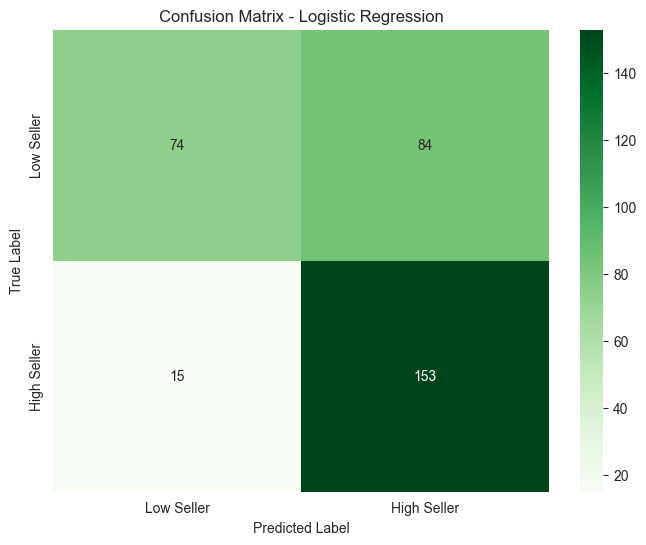


Confusion matrix saved to 'confusion_matrix_sales.png'

Performance Visualization


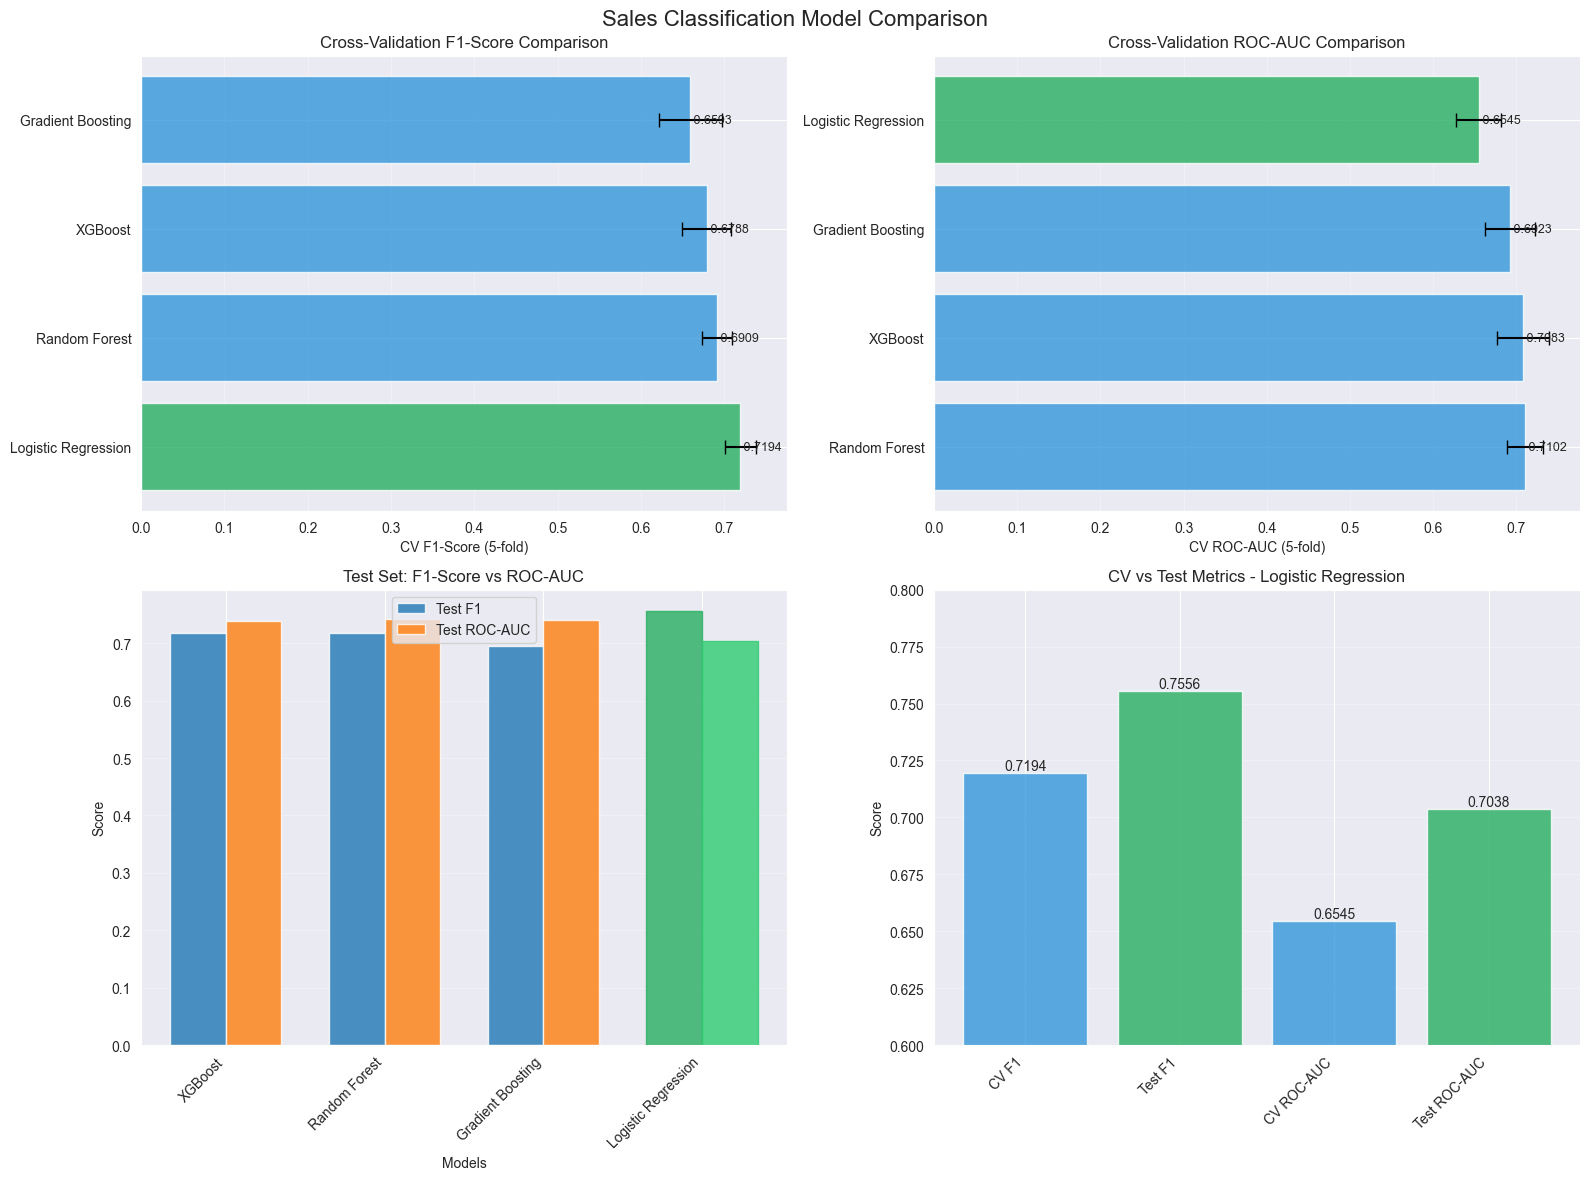


Visualization saved to 'sales_classification_model_comparison.png'


In [28]:
print("Detailed Evaluation - Best Sales Model")
print("="*70)

# final evaluation pada best model
y_pred_best = best_model_obj.predict(X_test_prod)
y_proba_best = best_model_obj.predict_proba(X_test_prod)[:, 1]

print(f"\nClassification Report - {best_sales_model}:")
print(classification_report(
    y_test_prod, y_pred_best,
    target_names=['Low Seller', 'High Seller']
))

# confusion matrix
cm = confusion_matrix(y_test_prod, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=['Low Seller', 'High Seller'],
    yticklabels=['Low Seller', 'High Seller']
)
plt.title(f'Confusion Matrix - {best_sales_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_sales.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to 'confusion_matrix_sales.png'")

# performance visualization
print("\n" + "="*70)
print("Performance Visualization")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Sales Classification Model Comparison', fontsize=16)

# plot 1: CV F1-Score dengan error bars
ax = axes[0, 0]
sorted_cv_f1 = comparison_table.sort_values('CV F1 Mean', ascending=False)
colors = ['#27ae60' if m == best_sales_model else '#3498db' for m in sorted_cv_f1.index]
bars = ax.barh(sorted_cv_f1.index, sorted_cv_f1['CV F1 Mean'], 
               xerr=sorted_cv_f1['CV F1 Std'], color=colors, alpha=0.8, capsize=5)
ax.set_xlabel('CV F1-Score (5-fold)')
ax.set_title('Cross-Validation F1-Score Comparison')
ax.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(sorted_cv_f1.iterrows()):
    ax.text(row['CV F1 Mean'], i, f" {row['CV F1 Mean']:.4f}", 
           va='center', fontsize=9)

# plot 2: CV ROC-AUC dengan error bars
ax = axes[0, 1]
sorted_cv_auc = comparison_table.sort_values('CV ROC-AUC Mean', ascending=False)
colors = ['#27ae60' if m == best_sales_model else '#3498db' for m in sorted_cv_auc.index]
bars = ax.barh(sorted_cv_auc.index, sorted_cv_auc['CV ROC-AUC Mean'],
               xerr=sorted_cv_auc['CV ROC-AUC Std'], color=colors, alpha=0.8, capsize=5)
ax.set_xlabel('CV ROC-AUC (5-fold)')
ax.set_title('Cross-Validation ROC-AUC Comparison')
ax.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(sorted_cv_auc.iterrows()):
    ax.text(row['CV ROC-AUC Mean'], i, f" {row['CV ROC-AUC Mean']:.4f}",
           va='center', fontsize=9)

# plot 3: test F1 vs test ROC-AUC
ax = axes[1, 0]
x = range(len(comparison_table))
width = 0.35
models_list = comparison_table.index.tolist()
f1_values = comparison_table['Test F1'].values
auc_values = comparison_table['Test ROC-AUC'].values

bars1 = ax.bar([i - width/2 for i in x], f1_values, width, label='Test F1', alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], auc_values, width, label='Test ROC-AUC', alpha=0.8)

for i, model in enumerate(models_list):
    if model == best_sales_model:
        bars1[i].set_color('#27ae60')
        bars2[i].set_color('#2ecc71')

ax.set_ylabel('Score')
ax.set_xlabel('Models')
ax.set_title('Test Set: F1-Score vs ROC-AUC')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# plot 4: CV vs Test validation
ax = axes[1, 1]
best_metrics = {
    'CV F1': comparison_table.loc[best_sales_model, 'CV F1 Mean'],
    'Test F1': comparison_table.loc[best_sales_model, 'Test F1'],
    'CV ROC-AUC': comparison_table.loc[best_sales_model, 'CV ROC-AUC Mean'],
    'Test ROC-AUC': comparison_table.loc[best_sales_model, 'Test ROC-AUC']
}

bars = ax.bar(best_metrics.keys(), best_metrics.values(), 
              color=['#3498db', '#27ae60', '#3498db', '#27ae60'], alpha=0.8)
ax.set_ylabel('Score')
ax.set_title(f'CV vs Test Metrics - {best_sales_model}')
ax.set_ylim([0.6, 0.8])
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('sales_classification_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'sales_classification_model_comparison.png'")

### 15. Sales Prediction - Apply Model to All Products

In [29]:
# prediksi sales category untuk semua produk
print("\nPredicting sales categories untuk semua produk...")

product_stats['predicted_sales_category'] = best_model_obj.predict(product_stats[features])
product_stats['predicted_sales_proba'] = best_model_obj.predict_proba(product_stats[features])[:, 1]

print(f"\nDistribusi predicted sales category:")
print(product_stats['predicted_sales_category'].value_counts())

# compare actual vs predicted
acc_all = accuracy_score(
    product_stats['sales_category'],
    product_stats['predicted_sales_category']
)
print(f"\nAccuracy prediksi (all products): {acc_all:.4f}")
print(f"Model used: {best_sales_model}")


Predicting sales categories untuk semua produk...

Distribusi predicted sales category:
predicted_sales_category
1    1190
0     437
Name: count, dtype: int64

Accuracy prediksi (all products): 0.6607
Model used: Logistic Regression


### 16. Recommendation System: Score Calculation

In [30]:
print("\n" + "="*70)
print("Hybrid Recommendation Score Calculation")
print("="*70)

def calc_recommendation_score(row):
    # formula: sentiment (40%) + sales proba (30%) + positive rate (20%) + review count (10%)
    sentiment_comp = row['avg_sentiment'] * 0.4
    sales_comp = row['predicted_sales_proba'] * 0.2
    positive_comp = row['positive_rate'] * 0.3
    review_comp = (min(row['review_count'], 100) / 100.0) * 0.1
    
    total = sentiment_comp + sales_comp + positive_comp + review_comp
    return min(total, 1.0)

product_stats['recommendation_score'] = product_stats.apply(
    calc_recommendation_score, axis=1
)

print(f"\nStatistik recommendation score:")
print(product_stats['recommendation_score'].describe())

# kategorisasi produk berdasarkan recommendation score
def get_category(score):
    if score >= 0.75:
        return 'Produk Unggulan'
    elif score >= 0.5:
        return 'Produk Stabil'
    else:
        return 'Perlu Evaluasi'

product_stats['recommendation_category'] = product_stats['recommendation_score'].apply(get_category)

print("\nDistribusi kategori rekomendasi:")
print(product_stats['recommendation_category'].value_counts())

# analisis per kategori
print("\n" + "="*70)
print("Analysis per Recommendation Category")
print("="*70)

for category in ['Produk Unggulan', 'Produk Stabil', 'Perlu Evaluasi']:
    subset = product_stats[product_stats['recommendation_category'] == category]
    if len(subset) > 0:
        print(f"\n{category} ({len(subset)} products):")
        print(f"  Recommendation score range: {subset['recommendation_score'].min():.3f} - {subset['recommendation_score'].max():.3f}")
        print(f"  Avg sentiment score: {subset['avg_sentiment'].mean():.3f}")
        print(f"  Avg sales probability: {subset['predicted_sales_proba'].mean():.3f}")
        print(f"  Avg positive rate: {subset['positive_rate'].mean():.3f}")
        print(f"  Avg review count: {subset['review_count'].mean():.1f}")
        print(f"  Avg actual item sold: {subset['item_sold'].mean():.1f}")


Hybrid Recommendation Score Calculation

Statistik recommendation score:
count    1627.000000
mean        0.766520
std         0.087184
min         0.053742
25%         0.744773
50%         0.801933
75%         0.805015
max         0.812133
Name: recommendation_score, dtype: float64

Distribusi kategori rekomendasi:
recommendation_category
Produk Unggulan    1155
Produk Stabil       437
Perlu Evaluasi       35
Name: count, dtype: int64

Analysis per Recommendation Category

Produk Unggulan (1155 products):
  Recommendation score range: 0.750 - 0.812
  Avg sentiment score: 0.942
  Avg sales probability: 0.599
  Avg positive rate: 1.000
  Avg review count: 4.9
  Avg actual item sold: 132.2

Produk Stabil (437 products):
  Recommendation score range: 0.506 - 0.750
  Avg sentiment score: 0.911
  Avg sales probability: 0.307
  Avg positive rate: 0.949
  Avg review count: 2.4
  Avg actual item sold: 27.7

Perlu Evaluasi (35 products):
  Recommendation score range: 0.054 - 0.497
  Avg sentim

### 17. Save Final Outputs & Model Configuration

In [31]:
print("\n" + "="*70)
print("Saving Final Outputs")
print("="*70)

# save product statistics dengan semua hasil
product_stats.to_csv('product_statistics_final.csv', index=False)
print("\nProduct statistics saved to 'product_statistics_final.csv'")

# save model configuration
config = {
    'approach': 'Hybrid: DNN Sentiment + Machine Learning Sales Classification',
    'models': {
        'sentiment_model': 'best_sentiment_model.h5',
        'sales_model': 'best_sales_classifier.pkl',
        'vectorizer': 'tfidf_vectorizer.pkl'
    },
    'dataset_info': {
        'columns': {
            'product': product_col,
            'review': review_col,
            'rating': rating_col
        },
        'features_used': features,
        'total_reviews': len(df),
        'total_products': len(product_stats)
    },
    'best_models': {
        'sentiment': best_model,
        'sales': best_sales_model
    },
    'model_performance': {
        'sentiment_f1': float(comparison_df.loc[best_model, 'f1']),
        'sentiment_roc_auc': float(comparison_df.loc[best_model, 'roc_auc']),
        'sales_cv_f1': float(comparison_table.loc[best_sales_model, 'CV F1 Mean']),
        'sales_test_roc_auc': float(comparison_table.loc[best_sales_model, 'Test ROC-AUC'])
    },
    'sales_threshold': float(median_sales),
    'hybrid_formula': {
        'sentiment_weight': 0.4,
        'sales_prediction_weight': 0.2,
        'positive_rate_weight': 0.3,
        'review_count_weight': 0.1
    },
    'recommendation_categories': {
        'Produk Unggulan': 'score >= 0.75',
        'Produk Stabil': '0.5 <= score < 0.75',
        'Perlu Evaluasi': 'score < 0.5'
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Model config saved to 'model_config.json'")

# summary statistics
print("\n" + "="*70)
print("Final Summary")
print("="*70)
print(f"\nTotal products analyzed: {len(product_stats)}")
print(f"Total reviews processed: {len(df)}")
print(f"\nRecommendation distribution:")
print(product_stats['recommendation_category'].value_counts())
print(f"\nBest sentiment model: {best_model}")
print(f"Best sales model: {best_sales_model}")
print(f"\nAll outputs saved successfully!")


Saving Final Outputs

Product statistics saved to 'product_statistics_final.csv'
Model config saved to 'model_config.json'

Final Summary

Total products analyzed: 1627
Total reviews processed: 6856

Recommendation distribution:
recommendation_category
Produk Unggulan    1155
Produk Stabil       437
Perlu Evaluasi       35
Name: count, dtype: int64

Best sentiment model: DNN
Best sales model: Logistic Regression

All outputs saved successfully!


### 18. Prediction Function Demo & Validation

In [32]:
# fungsi untuk prediksi hybrid recommendation (for deployment)
def predict_recommendation(product_name, df, sentiment_model, vectorizer, sales_model):
    # hybrid approach: sentiment DNN + sales prediction + formula
    
    # ambil reviews produk
    reviews = df[df[product_col] == product_name].copy()
    
    if len(reviews) == 0:
        return {'error': f"Product '{product_name}' not found"}
    
    # step 1: sentiment prediction
    reviews_tfidf = vectorizer.transform(reviews['cleaned_review'])
    raw_scores = sentiment_model.predict(reviews_tfidf.toarray(), verbose=0).flatten()
    
    # adjust sentiment based on rating
    def adjust_sentiment(rating, sentiment):
        if rating <= 1:
            return min(sentiment, 0.35)
        elif rating <= 2:
            return min(sentiment, 0.50)
        elif rating == 3:
            return max(min(sentiment, 0.70), 0.40)
        elif rating == 4:
            return max(min(sentiment, 0.90), 0.65)
        else:
            return min(max(sentiment, 0.80), 0.95)
    
    reviews['sentiment_score'] = [
        adjust_sentiment(r, s) 
        for r, s in zip(reviews[rating_col], raw_scores)
    ]
    
    # hitung fitur
    avg_sentiment = float(reviews['sentiment_score'].mean())
    std_sentiment = float(reviews['sentiment_score'].std())
    std_sentiment = 0.1 if pd.isna(std_sentiment) or std_sentiment == 0 else std_sentiment
    
    positive_rate = float((reviews[rating_col] >= 4).mean())
    avg_rating = float(reviews[rating_col].mean())
    std_rating = float(reviews[rating_col].std())
    std_rating = 0.1 if pd.isna(std_rating) or std_rating == 0 else std_rating
    
    review_count = len(reviews)
    
    # step 2: sales prediction
    feature_df = pd.DataFrame([{
        'avg_sentiment': avg_sentiment,
        'std_sentiment': std_sentiment,
        'positive_rate': positive_rate,
        'avg_rating': avg_rating,
        'std_rating': std_rating,
        'review_count': review_count
    }])
    
    sales_pred = int(sales_model.predict(feature_df)[0])
    sales_proba = float(sales_model.predict_proba(feature_df)[0, 1])
    
    # step 3: hybrid score
    sentiment_comp = avg_sentiment * 0.4
    sales_comp = sales_proba * 0.2
    positive_comp = positive_rate * 0.3
    review_comp = (min(review_count, 100) / 100.0) * 0.1
    
    score = min(sentiment_comp + sales_comp + positive_comp + review_comp, 1.0)
    
    # kategorisasi
    if score >= 0.75:
        category = 'Produk Unggulan'
    elif score >= 0.5:
        category = 'Produk Stabil'
    else:
        category = 'Perlu Evaluasi'
    
    return {
        'product_name': product_name,
        'recommendation_score': score,
        'recommendation_category': category,
        'sentiment_avg': avg_sentiment,
        'positive_rate': positive_rate,
        'review_count': review_count,
        'sales_category': 'High Seller' if sales_pred == 1 else 'Low Seller',
        'sales_proba': sales_proba
    }

print("\nHybrid prediction function ready")

# demo: test prediction function
print("\n" + "="*70)
print("Testing Prediction Function")
print("="*70)

# 3 produk dengan review terbanyak untuk demo
top_products = product_stats.nlargest(3, 'review_count')[product_col].tolist()

for i, product in enumerate(top_products, 1):
    print(f"\n{i}. {product}")
    print("-" * 70)
    
    result = predict_recommendation(
        product, df, sentiment_model, vectorizer, best_model_obj
    )
    
    if 'error' in result:
        print(f"Error: {result['error']}")
        continue
    
    print(f"Recommendation: {result['recommendation_category']}")
    print(f"Score: {result['recommendation_score']:.4f}")
    print(f"Sentiment: {result['sentiment_avg']:.4f}")
    print(f"Sales: {result['sales_category']} (proba: {result['sales_proba']:.4f})")
    print(f"Reviews: {result['review_count']}")

print("\n" + "="*70)
print("Prediction pipeline validated successfully")
print("="*70)


Hybrid prediction function ready

Testing Prediction Function



1. 2in1 Vacuum & Mopping Function)"
----------------------------------------------------------------------
Recommendation: Produk Unggulan
Score: 0.8040
Sentiment: 0.9471
Sales: High Seller (proba: 0.6009)
Reviews: 5

2. A416MAO-VIPS521 14",N5030/UMA/4G/256G PCIE/VIPS FHD/SLVR/OPI/WOSD
----------------------------------------------------------------------
Recommendation: Produk Unggulan
Score: 0.8003
Sentiment: 0.9375
Sales: High Seller (proba: 0.6017)
Reviews: 5

3. ASUS - E410MAO-HD455 INTEL® CELERON® N4020
----------------------------------------------------------------------
Recommendation: Produk Unggulan
Score: 0.8045
Sentiment: 0.9482
Sales: High Seller (proba: 0.6009)
Reviews: 5

Prediction pipeline validated successfully
